# Instrumentation Design 1
## Lab 4 - Loaded Voltage and Current Divider Circuits

Lab report by Matt Rixman

### 1. Loaded Voltage Divider Circuits

Objective 1: To find what effect load has on the voltage relationships in a voltage-divider circuit

Objective 2: To verify the results of objective 1 by experiment

The following resistors were used in the procedures below:

In [1]:
class Ohms:
    r1 = r2 = r3 = 1.2e3  # Ω

1. The above resistors were connected to match figure 1.3(a)


2. At 10V the following values were measured

| From Point | To Point |  Measured Voltage (V) |
|:-|:-|:-|
| B | D | 6.7 |
| C | D | 3.4 |

3-8. A potentiometer was added connecting points B and D and varied to match certain currents through the load.  Here is a redrawing of figure 1.3 (b) that makes the meshes more obvious:

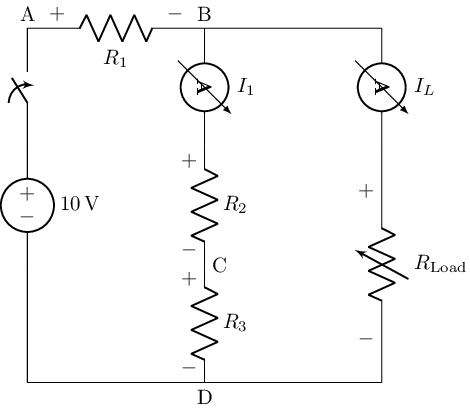

In [2]:
from lcapy import Circuit
cct = Circuit("""
V 0 12 {10}; down
SW 0 1 no; up
W 2 3; right=1.5
R1 1 2 {1200}; right=1.5, v=_, l=R_1
AM1 3 4; down, l=I_L
R_L 4 8; down=2, variable, l=R_{Load}, v=_
AM2 10 6; down, l=I_1
R2 6 7 {1200}; down, v=_, l=R_2
R3 7 11 {1200}; down, v=_, l=R_3
W 11 8; right 
W 11 9; left
W 9 12; up
A1 1; l=A, anchor=south
A2 2; l=B, anchor=south
A3 7; l=C, anchor=west
A4 11; l=D, anchor=north
""")
cct.draw(label_ids=False, draw_nodes=False, label_nodes=False)

The potentiomenter was adjusted to achielve the load currents (I<sub>L</sub>) below, and values were measured.  They're listed in step 9 for easy comparison

9. Calculations

First we write expressions for our resistors as voltage deltas in terms of clockwise mesh currents (I<sub>left</sub>, and I<sub>right</sub>)

In [3]:
# nothing to see here
from si_prefix import si_format as f  # used in table renderings
from sympy import symbols, Eq         # used for algebra
from sympy.solvers import solve
from IPython.display import display
r1, r2, r3, rload, rtotal = symbols('R_1, R_2, R_3, R_load, R_total')
vpwr, vab, vbc, vbd, vcd = symbols('V_pwr, V_ab, V_bc, V_bd, V_cd')
ileft, iright, ibleeder = symbols('I_left, I_right, I_bleeder')

# Ohm's law gives equations for each individual voltage drop
vab_r1 = r1 * (-ileft)
display(Eq(vab, vab_r1))

vbc_r2 = r2 * (-ileft + iright)
display(Eq(vbc, vbc_r2))

vcd_r3 = r3 * (-ileft + iright)
display(Eq(vcd, vcd_r3))

vbd_rload = rload * (-iright)
display(Eq(vbd, vbd_rload))


Then we write equations for those mesh currents in terms of the voltage deltas.

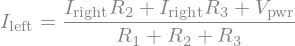

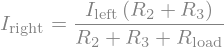

In [4]:
# clockwise from power supply
left_mesh = Eq(ileft, solve(Eq(0, sum([vpwr, vab_r1, vbc_r2, vcd_r3])), ileft)[0])
display(left_mesh)

# clockwise from B
right_mesh = Eq(iright, solve(Eq(0,sum([vbd_rload, -vbc_r2, -vcd_r3])), iright)[0])
display(right_mesh)

Solve the above equations as a system, include other equations to get derived values

In [5]:
def evaluate_at(iload_amps):
    return solve([
        # solve for currents
        left_mesh, right_mesh,
        
        # bleeder is superposition of left and right mesh currents
        # (which are in opposite directions)
        Eq(ibleeder, ileft - iright),
        
        # derive voltages
        Eq(vcd, vcd_r3),
        Eq(vbd, vbd_rload),
        
        # substitute values for symbols
        Eq(iright, iload_amps),
        Eq(r1, Ohms.r1),
        Eq(r2, Ohms.r2),
        Eq(r3, Ohms.r3),
        Eq(vpwr, 10),   # volts                      
        ])[0]    
    
at_load = { 2: evaluate_at(2e-3),
            4: evaluate_at(4e-3),
            6: evaluate_at(6e-3) }  # referenced in the table below

**Measured Values**

| Load Current (A) | Bleeder Current I<sub>1</sub> (A) |  B-D Voltage (V) |  C-D Voltage (V) | Load Resistance (Ω) |
|:-|:-|:-|:-|:-|
| 2m | 2.07m | -5.08 | -2.96 | 2.45k |
| 4m | 1.35m | -3.98 | -1.67 | 780 |
| 6m | 0.77m | -1.90 | -0.95 | 314 |

**Calculated Values**

| Load Current (A) | Bleeder Current I<sub>1</sub> (A) |  B-D Voltage (V) |  C-D Voltage (V) | Load Resistance (Ω) |
|:-|:-|:-|:-|:-|
| 2m | {{ f(at_load[2][ibleeder]) }} | {{f(at_load[2][vbd])}} | {{f(at_load[2][vcd])}} | {{f(at_load[2][rload])}} |
| 4m | {{ f(at_load[4][ibleeder]) }} | {{f(at_load[4][vbd])}} | {{f(at_load[4][vcd])}} | {{f(at_load[4][rload])}} |
| 6m | {{ f(at_load[6][ibleeder]) }} | {{f(at_load[6][vbd])}} | {{f(at_load[6][vcd])}} | {{f(at_load[6][rload])}} |

10.
a) As the load resistance decreses, the bleeder voltage also decreases.

b,c) Decreasing the load resistance 2500Ω->866Ω->311Ω caused the load current to increase 2mA->4mA->6mA and the bleeder current to decrease 2.1mA->1.4mA->0.78ma.  When we do this, we increase both the overall current that the circuit draw, and the proportion of that current that makes it through the load relative to the bleeder.

d) Increasing the load current 2mA->4mA->6mA reduced the total divider tap voltage 5.1V->3.5V->1.9V.  This is because the available current is given an increasted opportunity to "flow around" the divider, rather than through it, thus causing a reduced potential across it.

e) Our results compare favorably with the experimental data, (although it looks like we may have bumped the potentiometer sometime while taking measurements for the 4mA sample).

### 2. Designing Voltage-and-Current Divider Circuits

Objective 1: To design a voltage divider that will meet specified voltage and current requirements

Objective 2: To design a current divider that will meet specified current anf voltage requirements

Objective 3: To construct and test circuits to see that they meet the design requirements

#### A: Voltage Divider Circuit

We designed a circuit which accepts a 15V power supply and delivers 9V to two parallel branches.  It aims to deliver 3mA to the "load" branch, and 0.3mA to the "bleeder" branch.  It uses the following resistors.

In [6]:
r1 = 1.5e3
rbleeder = 30e3
rload = 3e3

r_bc = 1 / (1/rbleeder + 1/rload)
r_total = r1 + r_bc
i_total = 15 / r_total
v_ab = 15 * r1 / r_total
v_bc = 15 * r_bc / r_total
print("V_ab =", f(v_ab, precision=2))
print("V_bc =", f(v_bc, precision=2))
print("I_tot =", f(i_total, precision=2))

V_ab = 5.32 
V_bc = 9.68 
I_tot = 3.55 m


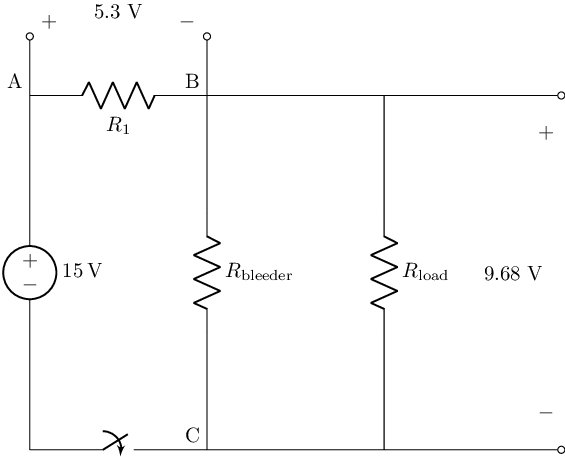

In [7]:
cct = Circuit("""
V 1 11 {15}; down
W 1 1_1; up=0.5
W 3 3_1; up=0.5
P 1_1 3_1; right, v=5.3 V
R1 1 3; right=1.5
W 3 4; down
W 3 6; right=1.5
W 6 5; down
Rbleeder 4 8 ; down
Rload 5 9 ; down
W 6 6_1; right=1.5
W 12 12_1; right=1.5
P 6_1 12_1; down, v=9.68 V
W 10 12; right
W 12 9; up
W 8 10; down
SW 11 10 no; right
A1 1; l=A, anchor=south east
A2 3; l=B, anchor=south east
A4 10; l=C, anchor=south east
""")
cct.draw(label_ids=False, draw_nodes=False, label_nodes=False)

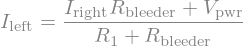

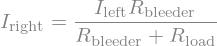

In [8]:
r1, rbleeder, rload = symbols('R_1, R_bleeder, R_load')
vpwr, vab, vbc = symbols('V_pwr, V_ab, V_bc')
ileft, iright, ibleeder = symbols('I_left, I_right, I_bleeder')

# Ohm's law gives equations for each individual voltage drop
# in terms of mesh currents
vab_r1 = r1 * (-ileft)
display(Eq(vab, vab_r1))

vbc_rbleeder = rbleeder * (-ileft + iright)
display(Eq(vbc, vbc_rbleeder))

vbc_rload = rload * (-iright)
display(Eq(vbc, vbc_rload))

# clockwise from power supply
left_mesh = Eq(ileft, solve(Eq(0, sum([vpwr, vab_r1, vbc_rbleeder])), ileft)[0])
display(left_mesh)

# clockwise from B
right_mesh = Eq(iright, solve(Eq(0,sum([vbc_rload, -vbc_rbleeder])), iright)[0])
display(right_mesh)

Solve the above equations as a system, include other equations to get derived values

In [9]:
def evaluate(r1_ohms, rbleeder_ohms, rload_ohms):
    return solve([
        # solve for currents
        left_mesh, right_mesh,
        
        # bleeder is superposition of left and right mesh currents
        # (which are in opposite directions)
        Eq(ibleeder, ileft - iright),
        
        # derive voltages
        Eq(vab, vab_r1),
        Eq(vbc, vbc_rbleeder),
        
        # bleeder = 10% of load
        Eq(ibleeder, 0.1 * iright),
        
        # replace resistor symbols with resistance values
        Eq(r1, r1_ohms),
        Eq(rbleeder, rbleeder_ohms),
        Eq(rload, rload_ohms),
        
        # include power supply
        Eq(vpwr, 15),   # volts                      
        ])[0]

values = evaluate(1.5e3, 30e3, 3e3)

**Calculated Values**

| Load Current (A) | Bleeder Current (A) |  A-B Voltage (V) | B-C Voltage (V) |
|:-|:-|:-|:-|
| {{ f(values[iright], precision=2) }} | {{f(values[ibleeder], precision=2)}} | {{f(values[vab], precision=2)}} | {{f(values[vbc])}} |

**Measured Values**

| Load Current (A) | Bleeder Current (A) |  A-B Voltage (V) | B-C Voltage (V) |
|:-|:-|:-|:-|
| {{ f(2.98e-3, precision=2) }} | {{f(0.30e-3, precision=2)}} | {{f(-6.03, precision=2)}} | {{f(-9.07, precision=2)}} |


#### B: Current Divider Circuit

We designed a circuit which accepts a 15V power supply and delivers 10V to three parallel branches.  It divides the current across those branches in a 1:2:3 ratio.  It uses the following resistors:

In [10]:
r1 = 1e3
r2 = 10e3
r3 = 6.8e3
r4 = 3.9e3    

r_bc = 1 / (1/r2 + 1/r3 + 1/r4)
r_total = r1 + r_bc
i_total = 15 / r_total
v_ab = 15 * r1 / r_total
v_bc = 15 * r_bc / r_total
print("V_ab =", f(v_ab, precision=2))
print("V_bc =", f(v_bc, precision=2))
print("I_tot =", f(i_total, precision=2))

V_ab = 5.02 
V_bc = 9.98 
I_tot = 5.02 m


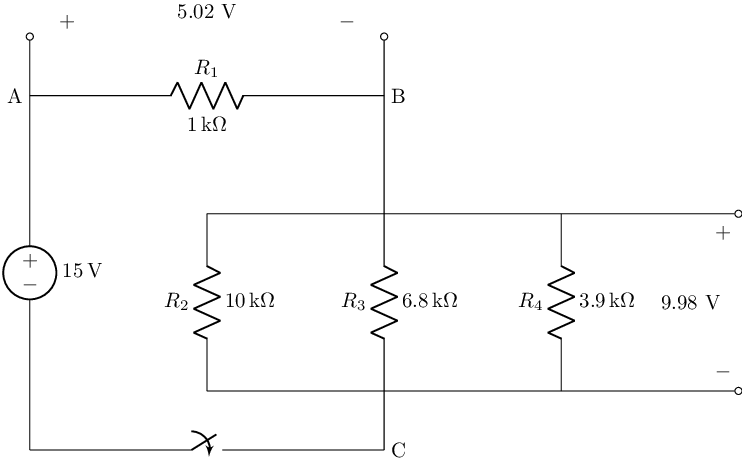

In [11]:
cct = Circuit("""
V 1 11 {15}; down
W 1 1_1; up=0.5
W 3 3_1; up=0.5
P 1_1 3_1; right, v=5.02 V
R1 1 3 {1000}; right=3, a=R_1
W 3 4; down=1
W 4 5; left=1.5
W 4 6; right=1.5
R2 5 7 {10000}; down=1.5, a=R_2
R3 4 8 {6800}; down=1.5, a=R_3
R4 6 9 (3900); down=1.5, a=R_4
W 6 6_1; right=1.5
W 9 9_1; right=1.5
P 6_1 9_1; down, v=9.98 V
W 7 8; right
W 8 9; right
W 8 10; down=0.5
SW 11 10 no; right
A1 1; l=A, anchor=east
A2 3; l=B, anchor=west
A4 10; l=C, anchor=west
""")
cct.draw(label_ids=False, draw_nodes=False, label_nodes=False)

In [12]:
# proportion of current down branch
def current_parallel(resistor):
    return i_total * r_bc / resistor

**Calculated Values**

| Resistor | Current (A) | Current Ratio vs Current at R<sub>2</sub> | 
|:-|:-|:-|
| R<sub>2</sub> | {{ f(current_parallel(r2)) }} | {{ "{:.2f}".format(current_parallel(r2)/current_parallel(r2))}} |
| R<sub>3</sub> | {{ f(current_parallel(r3)) }} | {{ "{:.2f}".format(current_parallel(r3)/current_parallel(r2)) }} |
| R<sub>4</sub> | {{ f(current_parallel(r4)) }} | {{ "{:.2f}".format(current_parallel(r4)/current_parallel(r2)) }} |
 
**Measured Values**

| Resistor | Current (A) | Current Ratio vs Current at R<sub>2</sub> | 
|:-|:-|:-|
| R<sub>2</sub> | 1.11m | {{ "{:.2f}".format(1.11 / 1.11) }} |
| R<sub>3</sub> | 1.42m | {{ "{:.2f}".format(1.42 / 1.11) }} |
| R<sub>4</sub> | 2.52m | {{ "{:.2f}".format(2.52 / 1.11) }} |
